# Experimentación Generación Molecular con MolGAN

## Introducción

En este notebook vamos a realizar la experimentación para la generación de moléculas con un dataset muy concreto haciendo uso de una red adversaria generativa MolGAN. La implementaremos haciendo uso de DeepChem, una librería de python centrada en la quimioinformática

## Dataset

La librería de DeepChem se empaqueta junto con el conjunto de datos MoleculeNet. MoleculeNet ha recopilado una amplia gama de conjuntos de datos y los ha cargado en objetos dc.data.Dataset de DeepChem para facilitar su uso a los usuarios. Para ver los distintos datasets que contiene MoleculeNet consultar: https://deepchem.readthedocs.io/en/latest/api_reference/moleculenet.html

El conjunto de datos utilizado para el entrenamiento del modelo es de un conjunto de compuestos los cuales se probó la capacidad para inhibir la replicación del VIH conteniendo más de 40,000 compuestos. Fue introducido por el Programa de Terapéutica de Medicamentos (DTP) en la Evaluación Antiviral del SIDA. Los resultados del cribado fueron evaluados y clasificados en tres categorías: confirmado inactivo (CI), confirmado activo (CA) y confirmado moderadamente activo (CM). Posteriormente, se combinaron las dos últimas etiquetas, convirtiéndolo en una tarea de clasificación entre inactivo (CI) y activo (CA y CM). 

Para más información sobre este dataset, consultar: 

https://deepchem.readthedocs.io/en/latest/api_reference/moleculenet.html#hiv-datase

https://wiki.nci.nih.gov/display/NCIDTPdata/AIDS+Antiviral+Screen+Data.

## Flujo de programación

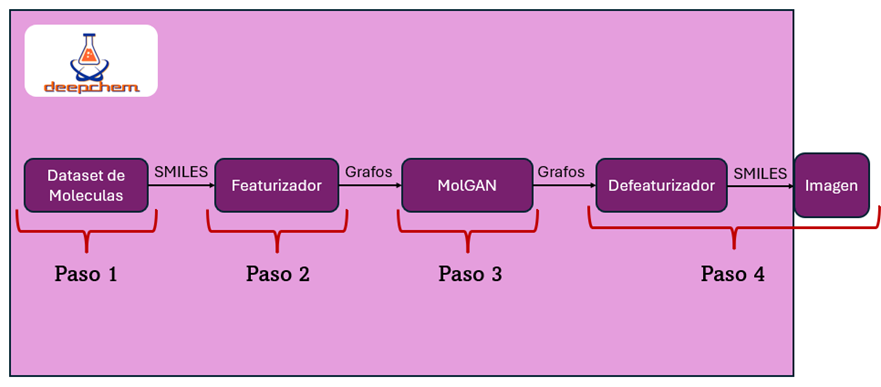

En el siguiente notebook seguiremos el flujo de programación establecido arriba. Primero cargaremos un Dataset de Moleculas donde obtendremos nuestras moléculas en formato SMILES. Más tarde, haremos uso de un featurizador (transformador) para transformar nuestros datos de tipo SMILES a Grafos, que es el formato de entrada válido en la MolGAN. Una vez obtenido nuestras moléculas en el formato deseado, procedemos a la inicialiación y entrenamiento de la MolGAN para posteriormente generar las moléculas. Una vez generada las moléculas, las defeaturizamos, es decir, la pasamos de grafos al formato SMILES. Todo esto lo lograremos gracias a la librería DeepChem. Por último, haciendo uso de la librería RDKit mostraremos la moléculas por pantalla 

Como mencionamos con anterioridad, haremos uso de la librería de DeepChem para el entrenamiento de una red adversaria generativa centrada en la generación molecular (MolGAN). Como podemos observar en el esquema de arriba, el flujo de programación será el siguiente:
* **Paso 0: Importar las librerías necesarias**
* **Paso 1: Cargar el dataset de moléculas del VIH haciendo uso de MoleculeNet.**
* **Paso 2: Inicialización y uso del featurizador en nuestro Dataset de Moleculas.**
* **Paso 3: Inicialización y entrenamiento de la MolGAN**
* **Paso 4: Generación y visualización de las moléculas**

### **Paso 0: Importar librerias necesarias**

Lo primero que debemos hacer es importar (e instalar) las librerías necesarias. En este caso, haremos uso de:
* DeepChem
* TensorFlow
* RDKit
* Pandas
* Numpy

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from collections import OrderedDict

import deepchem as dc
import deepchem.models
from deepchem.models import BasicMolGANModel as MolGAN
from deepchem.models.optimizers import ExponentialDecay
import tensorflow as tf
from tensorflow import one_hot
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

from deepchem.feat.molecule_featurizers.molgan_featurizer import GraphMatrix

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some PyTorch models, missing a dependency. No module named 'torch_geometric'
No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


### **Paso 1: Cargar el dataset de moléculas del VIH haciendo uso de MoleculeNet**

In [20]:
tasks, datasets, transformers = dc.molnet.load_hiv()
hiv_dataset = pd.DataFrame(data={'SMILES': datasets[0].ids})

### **Paso 2: Inicialización y uso del featurizador en nuestro Dataset de Moleculas**

Debido a la arquitectura de la MolGAN, debemos especificar el número máximo de átomos para codificar en el featurizador y la red adversaria. Cuanto mayor sea el número de átomos, más datos tendrás en el conjunto de datos. Sin embargo, esto también aumenta la complejidad del modelo, ya que las dimensiones de entrada se vuelven más altas lo que aumenta las probabilidad de que se vuelva inestable (es decir, no genere moléculas válidas)


In [21]:
num_atoms = 14

Establecemos el featurizador. DeepChem implementa ya un featurizador concreto para la MolGAN donde debemos indicar el número máximo de átomos con los que vamos a trabajar (max_atom_count) y los distintos átomos con los que vamos a trabajar (atom_labels). En este último, lo que hacemos es pasar el número atómico del átomo que queremos incluir. Aquellas moléculas que superen el número de átomos o contengan átomos no incluidos en atom_labels serán eliminadas
* 5 representaría el boro.
* 6 representaría el carbono.
* 7 representaría el nitrógeno.
* 8 representaría el oxígeno.
* 9 representaría el flúor.
* 11 representaría el sodio.
* 12 representaría el magnesio.
* 13 representaría el aluminio.
* 14 representaría el silicio.

In [22]:
#Inicializamos el featurizador
feat = dc.feat.MolGanFeaturizer(max_atom_count=num_atoms, atom_labels=[0, 5, 6, 7, 8, 9, 11, 12, 13, 14]) #15, 16, 17, 19, 20, 24, 29, 35, 53, 80])

Previamente a aplicar el featurizador a nuestras moléculas, vamos a filtrar nosotros las moleculas que excedan el número de átomos indicado para reducir el número de mensajes de error

In [23]:
smiles = hiv_dataset['SMILES'].values
filtered_smiles = [x for x in smiles if Chem.MolFromSmiles(x).GetNumAtoms() < num_atoms]
print("Número de moléculas obtenidas tras filtrar por el número de átomos:", len(filtered_smiles))

[15:51:35] WARNING: not removing hydrogen atom without neighbors
[15:51:35] WARNING: not removing hydrogen atom without neighbors


Número de moléculas obtenidas tras filtrar por el número de átomos: 2298


In [ ]:
# Realizamos la featurización de las moléculas de nuestro dataset previamente filtrada por el número de átomos. En este proceso lo que estamos haciendo
# es pasar de SMILES a grafos a traves del featurizador:
# SMILES ---FEATURIZADOR---> GRAFOS
features = feat.featurize(filtered_smiles)

A continuación removemos moléculas invalidas (que no sean de tipo GraphMatrix)

In [25]:
indices = [ i for i, data in enumerate(features) if type(data) is GraphMatrix ] #Nos quedamos con los indices de las moleculas validas
features = [features[i] for i in indices] #Filtramos por dichos indices
print("Número de moléculas obtenidas tras aplicar el featurizador:", len(features))

Número de moléculas obtenidas tras aplicar el featurizador: 1198


### **Paso 3: Inicialización y entrenamiento de la MolGAN**

Inicializamos el modelo MolGAN previamente importado de la librería de DeepChem. Este toma dos parámetros que son la tasa de aprendizaje (Learning Rate) que controla el tamaño de los pasos que se dan durante el proceso de optimización. En nuestro caso haremos uso de una exponencial decreciente con el fin de lograr mayor exploración en las primeras etapas del entrenamiento y una mayor estabilidad y convergencia en etapas posteriores. Tambien definiremos el número vertices que será el número de átomos que definimos previamente.

In [75]:
# Creamos el modelo creando una instancia de la clase MolGAN
gan = MolGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000), vertices=num_atoms)

# Separamos la información de nuestras moléculas en una matriz de nodos donde indicaremos el tipo de átomo que tiene cada nodo y una matriz de
# adyacencia donde indicaremos las relaciones entre los distintos nodos (como estan unidos entre sí).
dataset = dc.data.NumpyDataset([x.adjacency_matrix for x in features],[x.node_features for x in features])

Previamente al entrenamiento debemos definir una función iterbatches que nos separe los datos en distintos lotes para el entrenamiento de la MolGAN

In [76]:
#Función que nos va a generar los distintos lotes de datos con un tamaño determinado.
def iterbatches(epochs):
    for i in range(epochs):
        for batch in dataset.iterbatches(batch_size=gan.batch_size, pad_batches=True):
            adjacency_tensor = one_hot(batch[0], gan.edges)
            node_tensor = one_hot(batch[1], gan.nodes)
            yield {gan.data_inputs[0]: adjacency_tensor, gan.data_inputs[1]:node_tensor}

Entrenamos en modelo con la función fit_gan estableciendo las distintas épocas de entrenamiento y los pasos de aprendizaje del generador en función de los que da el discriminador. En este caso, como hemos establecido un generator_steps de 0.2 o 1/5, quiere decir que por cada 5 pasos que de el discriminador, el generador dará 1. Esto es así ya que estamos ante una WGAN. 

In [77]:
gan.fit_gan(iterbatches(25), generator_steps=0.2, checkpoint_interval=5000)

Ending global_step 299: generator average loss -5.41807, discriminator average loss -10.2712
TIMING: model fitting took 41.884 s


### **Paso 4: Generación y visualización de las moléculas**

Una vez entrenado el modelo únicamente nos queda generar las moléculas y visualizarlas. Para ello, haremos uso del método **predict_gan_generator(NumMoleculas)** que nos permitirá generar distintas muestras gracias al generador de la MolGAN

In [97]:
generated_data = gan.predict_gan_generator(10000)

Generating 10000 samples


Posteriormente desfeaturizamos nuestras moléculas obteniendolas en formato Mol de RDKit.

In [ ]:
nmols = feat.defeaturize(generated_data) #Realizamos la defeturarización de nuestras moléculas generadas para poder representarlas

Una vez desfeaturizadas las moléculas, removemos aquellas que sean invalidas debido a fallos durante la generación. Este es un paso crítico ya que si nuestro modelo es inestable, debido a que lo hemos entrenado con datos muy complejos (con un gran número de átomos por ejemplo), nos va a generar 0 moléculas válidas.

In [99]:
nmols = list(filter(lambda x: x is not None, nmols)) # Nos quedamos con los que no sean None
print ("{} valid molecules".format(len(nmols)))

5790 valid molecules


Por último, removemos las moléculas repetidas. Para ello, pasamos las moléculas en formato RDKitMol a SMILES y luego lo metemos en un diccionario y nos quedamos con las claves (serán los SMILES no repetidos). Posteriormente, para su representación, volvemos a convertirlas en formato RDKitMol.

In [100]:
nmols_smiles = [Chem.MolToSmiles(m) for m in nmols] # Conversión de RDMol a SMILES
nmols_smiles_unique = list(OrderedDict.fromkeys(nmols_smiles)) # Obtenemos las moléculas que no estan repetidas
nmols_viz = [Chem.MolFromSmiles(x) for x in nmols_smiles_unique] # Conversión de SMILES a RDMol
print ("{} unique valid molecules".format(len(nmols_viz))) #Imprimimos el número de moléculas únicas válidas

71 unique valid molecules


Por último nos queda representar las moléculas generadas por pantalla. Para ello, haremos uso de la clase Draw de RDKit y usaremos el método MolsToGridImage para obtener nuestras moléculas en formato RDMol a imagen.

In [101]:
img = Draw.MolsToGridImage(nmols_viz[0:len(nmols_viz)], molsPerRow=3, subImgSize=(250, 250), maxMols=len(nmols_viz), legends=None, returnPNG=False)

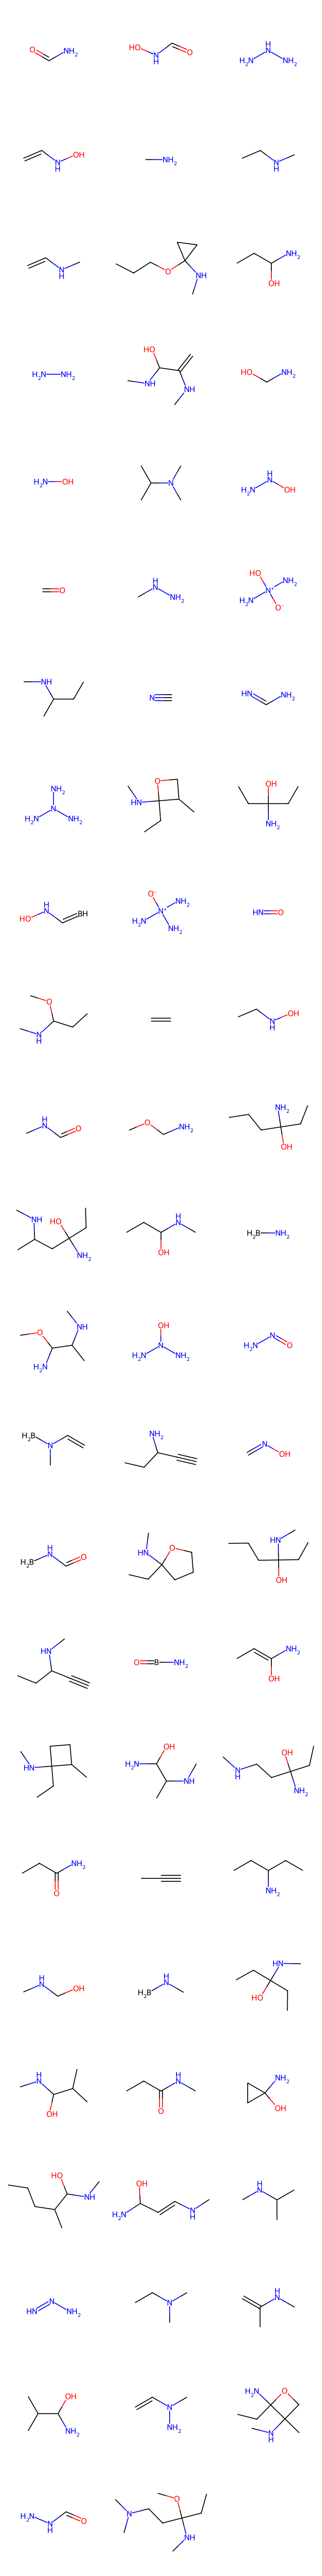

In [102]:
img #Representamos las moléculas generadas.

In [103]:
#SMILES obtenidos por el generador que son los que se han mostrado en la celda superior
nmols_smiles_unique

['NC=O',
 'O=CNO',
 'NNN',
 'C=CNO',
 'CN',
 'CCNC',
 'C=CNC',
 'CCCOC1(NC)CC1',
 'CCC(N)O',
 'NN',
 'C=C(NC)C(O)NC',
 'NCO',
 'NO',
 'CC(C)N(C)C',
 'NNO',
 'C=O',
 'CNN',
 'N[N+](N)([O-])O',
 'CCC(C)NC',
 'C#N',
 'N=CN',
 'NN(N)N',
 'CCC1(NC)OCC1C',
 'CCC(N)(O)CC',
 'B=CNO',
 'N[N+](N)(N)[O-]',
 'N=O',
 'CCC(NC)OC',
 'C=C',
 'CCNO',
 'CNC=O',
 'COCN',
 'CCCC(N)(O)CC',
 'CCC(N)(O)CC(C)NC',
 'CCC(O)NC',
 'BN',
 'CNC(C)C(N)OC',
 'NN(N)O',
 'NN=O',
 'BN(C)C=C',
 'C#CC(N)CC',
 'C=NO',
 'BNC=O',
 'CCC1(NC)CCCO1',
 'CCCC(O)(CC)NC',
 'C#CC(CC)NC',
 'NB=O',
 'CC=C(N)O',
 'CCC1(NC)CCC1C',
 'CNC(C)C(N)O',
 'CCC(N)(O)CCNC',
 'CCC(N)=O',
 'C#CC',
 'CCC(N)CC',
 'CNCO',
 'BNC',
 'CCC(O)(CC)NC',
 'CNC(O)C(C)C',
 'CCC(=O)NC',
 'NC1(O)CC1',
 'CCCC(C)C(O)NC',
 'CNC=CC(N)O',
 'CNC(C)C',
 'N=NN',
 'CCN(C)C',
 'C=C(C)NC',
 'CC(C)C(N)O',
 'C=CN(C)N',
 'CCC1(N)OCC1(C)NC',
 'NNC=O',
 'CCC(CCN(C)C)(NC)OC']